In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

In [2]:
def add_gaussian_noise(features, labels, std=0.1):
    noise = tf.random.normal(shape=tf.shape(features), mean=0.0, stddev=std, dtype=tf.float64)
    noisy_features = features + noise


    noise = tf.random.normal(shape=tf.shape(labels), mean=0.0, stddev=std, dtype=tf.float64)
    noisy_labels = labels + noise

    return noisy_features, noisy_labels

In [3]:

# 1. Load the California housing dataset from scikit-learn
data = fetch_california_housing()
X, y = data.data, data.target

# Reshape y to ensure it is 2D: (num_samples, 1)
y = y.reshape(-1, 1)

# 2. Normalize the features using StandardScaler (optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)




train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_ds = train_ds.map(lambda f, l: add_gaussian_noise(f, l, std=0.03))


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# 5. (Optional) Define a mapping function to ensure the label shapes are consistent
def format_data(features, labels):
    # Ensure labels are 2D tensors (batch_size, 1)
    labels = tf.reshape(labels, (-1, 1))
    return features, labels

# Apply the formatting function
train_ds = train_ds.map(format_data)
test_ds = test_ds.map(format_data)
val_ds = val_ds.map(format_data)

# 6. Batch, shuffle, and prefetch the datasets
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=50,         # Number of epochs to wait before stopping
    restore_best_weights=True,  # Restore model weights from the epoch with the best val_loss
    mode='min',          # Stop when val_loss stops decreasing
    verbose=1            # Print a message when training stops
)

In [5]:
def custom_metric(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true = tf.reshape(y_true, [-1])  # Force 1D shape: (batch_size,)
    y_pred = tf.reshape(y_pred, [-1])  # Force 1D shape: (batch_size,)
    MAE = tf.abs(y_pred - y_true)/y_true
    return tf.reduce_mean(MAE)

#Model1 MSE

In [7]:
# 7. Define the Keras model (input shape should match number of features: 8)
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # 8 features expected
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Single output for regression
])

# Compile the model with MSE loss and MAE as a metric
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])
model1.summary()

tf.random.set_seed(50)
np.random.seed(50)
random.seed(50)
# 8. Train the model using the training dataset and validate on the test dataset
history = model1.fit(train_ds, validation_data=val_ds, epochs=100 ,callbacks=[early_stopping])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.5057 - mae: 1.1566 - val_loss: 0.7181 - val_mae: 0.6090
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5912 - mae: 0.5516 - val_loss: 0.5536 - val_mae: 0.5023
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4629 - mae: 0.4784 - val_loss: 0.5119 - val_mae: 0.4754
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.4022 - mae: 0.4504 - val_loss: 0.4865 - val_mae: 0.4575
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.4030 - mae: 0.4431 - val_loss: 0.4060 - val_mae: 0.4530
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3822 - mae: 0.4368 - val_loss: 0.4395 - val_mae: 0.4475
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3830 - mae: 0.4351 - val_loss: 0.6979 - val_mae: 0.4565
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3744 - mae: 0.4267 - val_loss: 0.3684 - val_mae: 0.4366
Epoch 9/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2

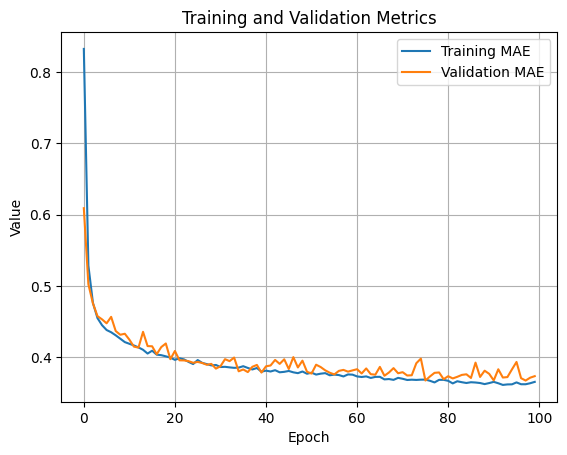

In [8]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [72]:
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])
loss, mae = model1.evaluate(test_ds)
print(f"Test MSE: {loss:.4f}, Test MAE: {mae:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2836 - mae: 0.3657
Test MSE: 0.2870, Test MAE: 0.3638


In [10]:
# 10. (Optional) Make predictions on a batch from the test dataset
for features_batch, labels_batch in test_ds.take(1):
    predictions = model1.predict(features_batch)
    print("Predictions (first 5):", predictions[:5].flatten())
    print("Actual Values (first 5):", labels_batch.numpy()[:5].flatten())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions (first 5): [0.56088656 1.1679384  4.7074018  2.5445359  2.422613  ]
Actual Values (first 5): [0.477   0.458   5.00001 2.186   2.78   ]


#Model 3 MAE

In [11]:
# 7. Define the Keras model (input shape should match number of features: 8)
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # 8 features expected
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Single output for regression
])

# Compile the model with MSE loss and MAE as a metric
model3.compile(optimizer='adam', loss='mae', metrics=['mae'])
model3.summary()
tf.random.set_seed(50)
np.random.seed(50)
random.seed(50)
# 8. Train the model using the training dataset and validate on the test dataset
history = model3.fit(train_ds, validation_data=val_ds, epochs=100 ,callbacks=[early_stopping])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1273 - mae: 1.1273 - val_loss: 0.5502 - val_mae: 0.5502
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5038 - mae: 0.5038 - val_loss: 0.4732 - val_mae: 0.4732
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4491 - mae: 0.4491 - val_loss: 0.4497 - val_mae: 0.4497
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4332 - mae: 0.4332 - val_loss: 0.4403 - val_mae: 0.4403
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4227 - mae: 0.4227 - val_loss: 0.4260 - val_mae: 0.4260
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4111 - mae: 0.4111 - val_loss: 0.4246 - val_mae: 0.4246
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4132 - mae: 0.4132 - val_loss: 0.4136 - val_mae: 0.4136
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4013 - mae: 0.4013 - val_loss: 0.4114 - val_mae: 0.4114
Epoch 9/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

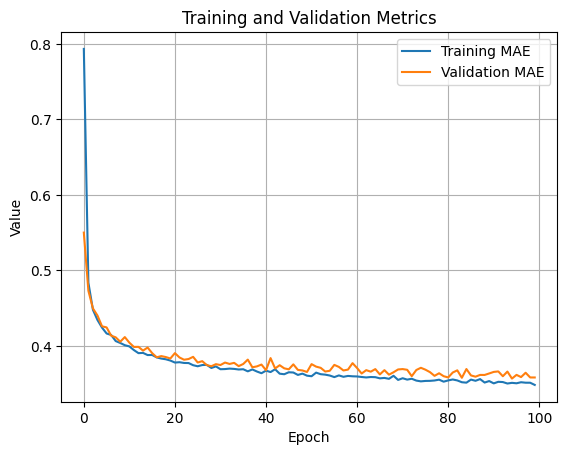

In [12]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [71]:
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])
loss, mae = model3.evaluate(test_ds)
print(f"Test MSE: {loss:.4f}, Test MAE: {mae:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2958 - mae: 0.3561
Test MSE: 0.3022, Test MAE: 0.3560


In [14]:
# 10. (Optional) Make predictions on a batch from the test dataset
for features_batch, labels_batch in test_ds.take(1):
    predictions = model3.predict(features_batch)
    print("Predictions (first 5):", predictions[:5].flatten())
    print("Actual Values (first 5):", labels_batch.numpy()[:5].flatten())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predictions (first 5): [0.45819628 1.2120878  4.6659517  2.402032   2.5648682 ]
Actual Values (first 5): [0.477   0.458   5.00001 2.186   2.78   ]


#Model2 Purposed Loss

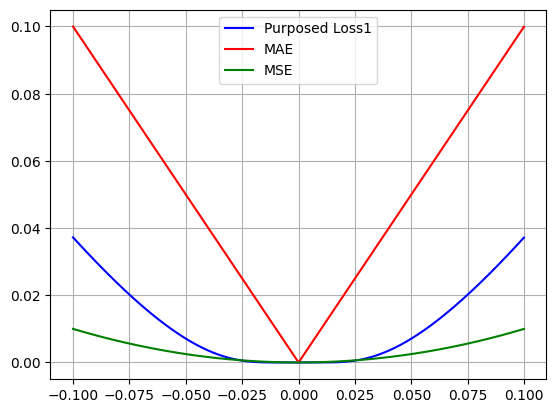

In [100]:
X=np.arange(-0.1,0.1,0.0001)
C=400

Fx=((abs(X*C)/(1+abs(X*C)))**40)*abs(X)

Gx=abs(X)
Hx=X**2

#Fx=(X**4+4*X**2+1)/(X**4+1.76*X**3+3.1*X**2+1.76*X+1)

plt.plot(X,Fx,label='Purposed Loss1', color='blue')
plt.plot(X,Gx, label='MAE', color='red')
plt.plot(X,Hx, label='MSE', color='green')
plt.grid(True)
plt.legend()

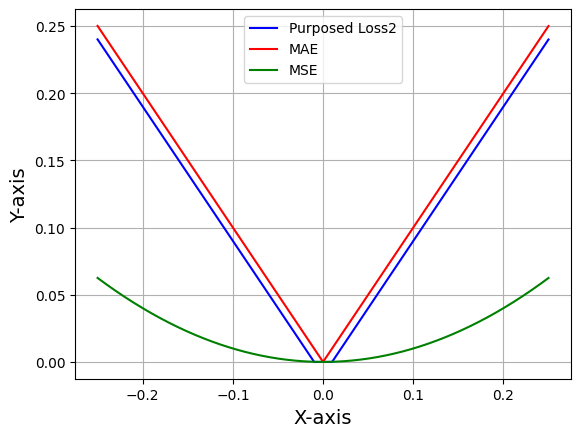

In [101]:
X=np.arange(-0.25,0.25,0.0001)
C=400

Fx=((abs(X*C)/(1+abs(X*C)))**40)*abs(X)

Fx=np.where(abs(X)>0.01,abs(X)-0.01,0)

Gx=abs(X)

Hx=X**2

#Fx=(X**4+4*X**2+1)/(X**4+1.76*X**3+3.1*X**2+1.76*X+1)

plt.plot(X,Fx,label='Purposed Loss2', color='blue')
plt.plot(X,Gx, label='MAE', color='red')
plt.plot(X,Hx, label='MSE', color='green')

plt.xlabel('X-axis', fontsize=14, fontname='Comic Sans MS')  # Label for the x-axis
plt.ylabel('Y-axis', fontsize=14, fontname='Comic Sans MS')  # Label for the y-axis
#plt.title('High Pass Filter', fontsize=16, fontname='Comic Sans MS')  # Title of the graph
plt.grid(True)
plt.legend()

In [17]:
# Define a custom loss function
def custom_loss(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    y_true = tf.reshape(y_true, [-1])  # Force 1D shape: (batch_size,)
    y_pred = tf.reshape(y_pred, [-1])  # Force 1D shape: (batch_size,)

    Th=0.05
    conditional_mse = tf.reduce_mean(tf.where(tf.abs(y_true - y_pred)>Th,tf.abs(y_true - y_pred)-Th,0))
    return conditional_mse

In [18]:
def custom_loss(y_true, y_pred):
    C=400
    Poww=40

    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    y_true = tf.reshape(y_true, [-1])  # Force 1D shape: (batch_size,)
    y_pred = tf.reshape(y_pred, [-1])  # Force 1D shape: (batch_size,)

    X=tf.abs(y_true-y_pred)

    LOSS=((tf.abs(X*C)/(1+tf.abs(X*C)))**Poww)*tf.abs(X)

    return tf.reduce_mean(LOSS)

In [19]:
# 7. Define the Keras model (input shape should match number of features: 8)
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # 8 features expected
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Single output for regression
])

# Compile the model with MSE loss and MAE as a metric
model2.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])
model2.summary()

tf.random.set_seed(50)
np.random.seed(50)
random.seed(50)
# 8. Train the model using the training dataset and validate on the test dataset
history = model2.fit(train_ds, validation_data=val_ds, epochs=100,callbacks=[early_stopping])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0436 - mae: 1.1310 - val_loss: 0.4638 - val_mae: 0.5434
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4233 - mae: 0.5016 - val_loss: 0.3908 - val_mae: 0.4676
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3724 - mae: 0.4491 - val_loss: 0.3686 - val_mae: 0.4451
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3585 - mae: 0.4349 - val_loss: 0.3567 - val_mae: 0.4331
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3467 - mae: 0.4225 - val_loss: 0.3513 - val_mae: 0.4277
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3414 - mae: 0.4171 - val_loss: 0.3433 - val_mae: 0.4191
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3310 - mae: 0.4064 - val_loss: 0.3395 - val_mae: 0.4154
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3275 - mae: 0.4021 - val_loss: 0.3379 - val_mae: 0.4136
Epoch 9/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

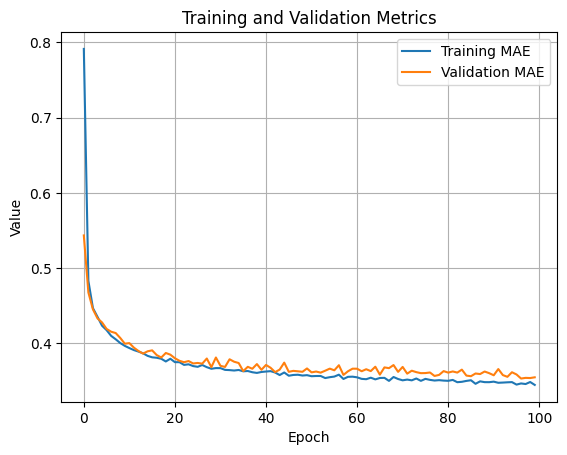

In [20]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [70]:
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])
loss, mae = model2.evaluate(test_ds)
print(f"Test MSE: {loss:.4f}, Test MAE: {mae:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2858 - mae: 0.3499
Test MSE: 0.2940, Test MAE: 0.3491


In [22]:
# 10. (Optional) Make predictions on a batch from the test dataset
for features_batch, labels_batch in test_ds.take(1):
    predictions = model1.predict(features_batch)
    print("Predictions (first 5):", predictions[:5].flatten())
    print("Actual Values (first 5):", labels_batch.numpy()[:5].flatten())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predictions (first 5): [0.56088656 1.1679384  4.7074018  2.5445359  2.422613  ]
Actual Values (first 5): [0.477   0.458   5.00001 2.186   2.78   ]


#In summery
Purposed Loss: Test MSE: 0.2940, Test MAE: 0.3491;

MSE Loss: Test MSE: 0.2870, Test MAE: 0.3638;

MAE Loss:Test MSE: 0.3022, Test MAE: 0.3560;

#Statistical Test

#Between porposed loss and MAE

In [86]:
from scipy import stats

error_1 = model2.predict(test_ds).flatten()#-y_test.flatten()
error_2 = model3.predict(test_ds).flatten()#-y_test.flatten()



# Kolmogorov-Smirnov (KS) Test
ks_stat, ks_p_value = stats.ks_2samp(error_1, error_2)
print("KS Test Statistic:", ks_stat)
print("KS Test p-value:", ks_p_value)

# Independent Samples T-test
t_stat, t_p_value = stats.ttest_ind(error_1, error_2)
print("T-test Statistic:", t_stat)
print("T-test p-value:", t_p_value)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
KS Test Statistic: 0.02616279069767442
KS Test p-value: 0.11852613429888001
T-test Statistic: 1.1046593405807752
T-test p-value: 0.2693394278773456


#Between porposed loss and MSE

In [87]:
from scipy import stats

error_1 = model2.predict(test_ds).flatten()#-y_test.flatten()
error_2 = model1.predict(test_ds).flatten()#-y_test.flatten()



# Kolmogorov-Smirnov (KS) Test
ks_stat, ks_p_value = stats.ks_2samp(error_1, error_2)
print("KS Test Statistic:", ks_stat)
print("KS Test p-value:", ks_p_value)

# Independent Samples T-test
t_stat, t_p_value = stats.ttest_ind(error_1, error_2)
print("T-test Statistic:", t_stat)
print("T-test p-value:", t_p_value)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
KS Test Statistic: 0.037306201550387594
KS Test p-value: 0.006392403369427693
T-test Statistic: -3.0411897956901255
T-test p-value: 0.0023638474878032506


# Based on the statistical tests, the error distribution of the model that used the proposed loss is significantly different from those of the models trained with MAE and MSE.

#Predicting

In [93]:
def Evaluating_Price(In,Y_purposed_price):
  In_Scaled=scaler.transform(In)
  M1=model2.predict( In_Scaled)
  M1=M1*100000

  if(Y_purposed_price>M1[0,0]):
    return "This price is probably %f higher than the price it should be."%(Y_purposed_price-M1[0,0])
  else:
    return "✅This price is probably %f lower than the price it should be."%(M1[0,0]-Y_purposed_price)
  return(M1)

In [94]:
Features__ = np.array([[   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ]])

In [95]:
Y_purposed_price=4.06*100000

In [96]:
Evaluating_Price(Features__,Y_purposed_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


'✅This price is probably 9542.312500 lower than the price it should be.'